<a href="https://colab.research.google.com/github/Datamin-D/Projects/blob/main/%5BLG_data_con%5D_EDA_%26_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Loading Data 

In [ ]:
#아이디어: 시간 별로 언제.. 문제가 일어났는지 살펴 볼 수 있을듯.

In [ ]:
#connecting gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install pycaret
from pycaret.classification import *

     |████████████████████████████████| 256kB 8.1MB/s 
     |████████████████████████████████| 157.5MB 77kB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 65.8MB 104kB/s 
     |████████████████████████████████| 6.8MB 54.0MB/s 
     |████████████████████████████████| 174kB 66.1MB/s 
     |████████████████████████████████| 245kB 66.3MB/s 
     |████████████████████████████████| 1.8MB 53.9MB/s 
     |████████████████████████████████| 276kB 55.3MB/s 
     |████████████████████████████████| 14.2MB 45.7MB/s 
     |████████████████████████████████| 1.6MB 45.8MB/s 
     |████████████████████████████████| 2.1MB 50.4MB/s 
     |████████████████████████████████| 604kB 46.5MB/s 
     |████████████████████████████████| 3.1MB 45.3MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 1.1MB 41.9MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 163kB 53.4

In [ ]:
#libraries
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm,tqdm_pandas
#https://doubly12f.tistory.com/56 참조 가능.
from sklearn.metrics import *
from sklearn.model_selection import KFold

#시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
#모델

#NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten,Conv1D,MaxPooling1D,GlobalAveragePooling1D,Reshape
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
PATH = '/gdrive/MyDrive/대회, 프로젝트/LG data con/'

In [ ]:
# loading data
PATH = '/gdrive/MyDrive/대회, 프로젝트/LG data con/'
sample_submission = pd.read_csv('/gdrive/MyDrive/대회, 프로젝트/LG data con/sample_submission.csv')
test_err = pd.read_csv('/gdrive/MyDrive/대회, 프로젝트/LG data con/test_err_data.csv')
test_quality = pd.read_csv('/gdrive/MyDrive/대회, 프로젝트/LG data con/test_quality_data.csv')
train_err = pd.read_csv('/gdrive/MyDrive/대회, 프로젝트/LG data con/train_err_data.csv')
train_problem = pd.read_csv('/gdrive/MyDrive/대회, 프로젝트/LG data con/train_problem_data.csv')
train_quality = pd.read_csv('/gdrive/MyDrive/대회, 프로젝트/LG data con/train_quality_data.csv')

# 2.Preprocessing

## train_err, test_err

In [ ]:
train_err

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0
...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1
16554659,24999,20201130172625,model_3,05.15.2138,16,1
16554660,24999,20201130172625,model_3,05.15.2138,4,0
16554661,24999,20201130172631,model_3,05.15.2138,4,0


In [ ]:
# # time 컬럼 전처리 #datetime분석가능한 형태로.

# # pandas datetime을 활용할 수 있는 형태로 바꿔주기
# def divide_time(time):
#   time = str(time)
#   Year = time[:4]
#   Month = time[4:6]
#   Day = time[6:8]
#   Hour = time[8:10]
#   minute = time[10:12]
#   second = time[12:]
#   #print(Year+"-"+Month+"-"+Day+" "+Hour+":"+minute+":"+second)
#   return Year+"-"+Month+"-"+Day+" "+Hour+":"+minute+":"+second
#train_err['parsed_time']= train_err['time'].map(lambda x: divide_time(x))
# 이럴필요 없음. pd.date_time(df['컬럼'],format = '') 쓰면됨.


#train
train_err
train_err['parsed_time'] = pd.to_datetime(train_err['time'],format ='%Y%m%d%H%M%S') # format으로 datetime인지가능
train_err.drop(['time'],axis = 1,inplace = True)
#test도 
test_err
test_err['parsed_time'] = pd.to_datetime(test_err['time'],format ='%Y%m%d%H%M%S') 
test_err.drop(['time'],axis = 1,inplace = True)


In [ ]:
#train_err 날짜 분해
train_err["year"] = train_err["parsed_time"].dt.year
train_err["month"] = train_err["parsed_time"].dt.month
train_err["day"] = train_err["parsed_time"].dt.day
train_err["hour"] = train_err["parsed_time"].dt.hour
train_err["minute"] = train_err["parsed_time"].dt.minute
train_err["second"] = train_err["parsed_time"].dt.second

# dayofweek는 날짜에서 요일(월~일)을 가져오는 기능입니다.
# 값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다.
train_err["datetime-dayofweek"] = train_err["parsed_time"].dt.dayofweek
train_err

,user_id,model_nm,fwver,errtype,errcode,parsed_time,year,month,day,hour,minute,second,datetime-dayofweek
0,10000,model_3,05.15.2138,15,1,2020-11-01 02:56:16,2020,11,1,2,56,16,6
1,10000,model_3,05.15.2138,12,1,2020-11-01 03:03:09,2020,11,1,3,3,9,6
2,10000,model_3,05.15.2138,11,1,2020-11-01 03:03:09,2020,11,1,3,3,9,6
3,10000,model_3,05.15.2138,16,1,2020-11-01 05:05:14,2020,11,1,5,5,14,6
4,10000,model_3,05.15.2138,4,0,2020-11-01 05:05:15,2020,11,1,5,5,15,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16554658,24999,model_3,05.15.2138,15,1,2020-11-30 16:30:51,2020,11,30,16,30,51,0
16554659,24999,model_3,05.15.2138,16,1,2020-11-30 17:26:25,2020,11,30,17,26,25,0
16554660,24999,model_3,05.15.2138,4,0,2020-11-30 17:26:25,2020,11,30,17,26,25,0
16554661,24999,model_3,05.15.2138,4,0,2020-11-30 17:26:31,2020,11,30,17,26,31,0


In [ ]:
#test_err 날짜 분해

test_err["year"] = test_err["parsed_time"].dt.year
test_err["month"] = test_err["parsed_time"].dt.month
test_err["day"] = test_err["parsed_time"].dt.day
test_err["hour"] = test_err["parsed_time"].dt.hour
test_err["minute"] = test_err["parsed_time"].dt.minute
test_err["second"] = test_err["parsed_time"].dt.second
test_err["datetime-dayofweek"] = test_err["parsed_time"].dt.dayofweek
test_err

## train_quality, test_quality

In [ ]:
train_quality

In [ ]:
#time 컬럼 전처리

#train

train_quality['parsed_time'] = pd.to_datetime(train_quality['time'],format ='%Y%m%d%H%M%S') # format으로 datetime인지가능
train_quality.drop(['time'],axis = 1,inplace = True)
#test도 

test_quality['parsed_time'] = pd.to_datetime(test_quality['time'],format ='%Y%m%d%H%M%S') 
test_quality.drop(['time'],axis = 1,inplace = True)


##  train_problem

In [ ]:
#time 컬럼 전처리
train_problem['err_received_time'] = pd.to_datetime(train_problem['time'],format = "%Y%m%d%H%M%S")
train_problem.drop(['time'],axis = 1,inplace = True)
train_problem

#train_err 날짜 분해
train_problem["year"] = train_problem["err_received_time"].dt.year
train_problem["month"] = train_problem["err_received_time"].dt.month
train_problem["day"] = train_problem["err_received_time"].dt.day
train_problem["hour"] = train_problem["err_received_time"].dt.hour
train_problem["minute"] = train_problem["err_received_time"].dt.minute
train_problem["second"] = train_problem["err_received_time"].dt.second

# dayofweek는 날짜에서 요일(월~일)을 가져오는 기능입니다.
# 값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다.
train_err["datetime-dayofweek"] = train_err["err_received_time"].dt.dayofweek
train_err

#

KeyError: ignored

## train데이터 합치기

[우선 채택] 선택1 train_problem과 train err, quality를 합칠 때 단순히 user id와 대응해서 전부 합친다. 


In [ ]:
#pd.merge(train_err,train_problem,how = 'inner',on = 'user_id',)
#좀더 고민해보기.

,user_id,model_nm,fwver,errtype,errcode,parsed_time,year,month,day,hour,minute,second,datetime-dayofweek,err_received_time
0,10001,model_2,04.33.1185,15,1,2020-11-01 02:04:15,2020,11,1,2,4,15,6,2020-11-13 19:00:00
1,10001,model_2,04.33.1185,15,1,2020-11-01 02:04:15,2020,11,1,2,4,15,6,2020-11-13 19:00:00
2,10001,model_2,04.33.1185,31,1,2020-11-01 02:04:15,2020,11,1,2,4,15,6,2020-11-13 19:00:00
3,10001,model_2,04.33.1185,33,2,2020-11-01 02:04:15,2020,11,1,2,4,15,6,2020-11-13 19:00:00
4,10001,model_2,04.33.1185,12,1,2020-11-01 02:04:21,2020,11,1,2,4,21,6,2020-11-13 19:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8615264,24998,model_0,04.22.1778,15,1,2020-11-29 05:08:46,2020,11,29,5,8,46,6,2020-11-10 21:00:00
8615265,24998,model_0,04.22.1778,16,1,2020-11-30 13:26:04,2020,11,30,13,26,4,0,2020-11-10 21:00:00
8615266,24998,model_0,04.22.1778,31,0,2020-11-30 13:26:24,2020,11,30,13,26,24,0,2020-11-10 21:00:00
8615267,24998,model_0,04.22.1778,40,1,2020-11-30 21:03:51,2020,11,30,21,3,51,0,2020-11-10 21:00:00


In [ ]:
train_err[train_err.user_id == 10001]

,user_id,model_nm,fwver,errtype,errcode,parsed_time,year,month,day,hour,minute,second,datetime-dayofweek
317,10001,model_2,04.33.1185,15,1,2020-11-01 02:04:15,2020,11,1,2,4,15,6
318,10001,model_2,04.33.1185,15,1,2020-11-01 02:04:15,2020,11,1,2,4,15,6
319,10001,model_2,04.33.1185,31,1,2020-11-01 02:04:15,2020,11,1,2,4,15,6
320,10001,model_2,04.33.1185,33,2,2020-11-01 02:04:15,2020,11,1,2,4,15,6
321,10001,model_2,04.33.1185,12,1,2020-11-01 02:04:21,2020,11,1,2,4,21,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,10001,model_2,04.33.1261,41,NFANDROID2,2020-11-30 19:36:49,2020,11,30,19,36,49,0
2678,10001,model_2,04.33.1261,15,1,2020-11-30 21:40:26,2020,11,30,21,40,26,0
2679,10001,model_2,04.33.1261,16,1,2020-11-30 22:26:25,2020,11,30,22,26,25,0
2680,10001,model_2,04.33.1261,31,1,2020-11-30 22:26:26,2020,11,30,22,26,26,0


In [ ]:
# train_problem에 있는 아이디면 problem = 1 로 넣기,.
#problem = np.zeros(15000)



train_err == 

True

In [ ]:
# # train_err, train_problem 합치기 하지마셈
# def record_user_err(user_id):
#  if user_id in train_problem.user_id.unique():
#    return 1
# tqdm.pandas()
# train_err['problem'] = train_err['user_id'].progress_apply(lambda x: record_user_err(x))

Streaming output truncated to the last 5000 lines.
 31%|███       | 5135014/16554663 [19:05<1:22:28, 2307.74it/s]

KeyboardInterrupt: ignored

In [ ]:
train_problem

,user_id,err_received_time
0,19224,2020-11-02 20:00:00
1,23664,2020-11-16 14:00:00
2,15166,2020-11-14 13:00:00
3,12590,2020-11-08 21:00:00
4,15932,2020-11-03 21:00:00
...,...,...
5424,20167,2020-11-25 12:00:00
5425,16270,2020-11-10 12:00:00
5426,19114,2020-11-06 23:00:00
5427,21505,2020-11-04 11:00:00


In [ ]:
id_error

array([[10000,    15],
       [10000,    12],
       [10000,    11],
       ...,
       [24999,     4],
       [24999,     4],
       [24999,    15]])

In [ ]:

#어떤 타입의 에러가 발생했는지.
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error): #tqdm(리스트) -->하면 리스트를 도는 반복문 추이를 보여줌.
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

#문제가 접수 되었는지. 
problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1 
problem
train = pd.DataFrame(data=error)
train['problem'] = problem
del error, problem

# clf = setup(data = train, target = 'problem') 
# #
# best_5 = compare_models(sort = 'Accuracy', n_select = 5)
# #
# blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')
# #
# pred_holdout = predict_model(blended)
# #
# final_model = finalize_model(blended)
# #
# test_err  = pd.read_csv(PATH+'test_err_data.csv')
# id_error = test_err[['user_id','errtype']].values
# test_x = np.zeros((14999,42))
# for person_idx, err in tqdm(id_error):
#     test_x[person_idx - 30000,err - 1] += 1
# test_x = test_x.reshape(test_x.shape[0],-1)
# test = pd.DataFrame(data=test_x)
# #
# predictions = predict_model(final_model, data = test)
# #
# #pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
# x = []
# for i in range(len(predictions['Score'])):
#   if predictions['Label'][i] =='1.0':
#     x.append(predictions['Score'][i])
#   else:
#     x.append(1-predictions['Score'][i])
# #
# sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
# sample_submssion['problem'] = x
# sample_submssion.to_csv("AutoML.csv", index = False)

  5%|▍         | 816457/16554663 [00:02<00:48, 327721.35it/s]


KeyboardInterrupt: ignored

In [ ]:
train = pd.DataFrame(data=error)
train['problem'] = problem
del error, problem

In [ ]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,problem
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


선택2 err received time 이전의 기록들에만 합친다

error 접수된 datetime 이전에 해당하냐 아니냐로 하면 될듯.. 

#3.EDA

-데이터 합쳐야하나..? 뭘? 

-결측치도 확인

##train_err

In [ ]:
train_err
#시스템에 발생한 에러 로그

#errtype? errcode? 차이?
#fwver는? Firmware Version인듯.
#model_nm? Q 모델 네임. 무슨 모델?
#시스템에 발생한 에러 로그

#errtype? errcode? 차이?
#fwver는? Firmware Version인듯.
#model_nm? Q 모델 네임. 무슨 모델?

### user 몇명?

In [ ]:
err_user = train_err['user_id'].value_counts() #Series.value_counts() 하면 유일한 값 별로 세어줌
err_user
#15000명의 유저

24934    222186
20546    195538
15570    175730
20352     83680
11041     66093
          ...  
19372         1
18544         1
20099         1
13198         1
12367         1
Name: user_id, Length: 15000, dtype: int64

In [ ]:
train_err['user_id'].value_counts().max()
#최대 222186건의 에러 로그 발견.최소는 물론1

222186

In [ ]:
err_user.sort_values(ascending = False,inplace = True)
err_user.iloc[:100]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44867 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51086 missing from current font.
  font.set_

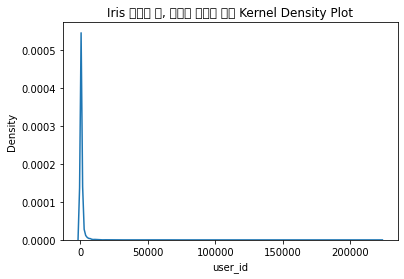

In [ ]:
# 유저별 오류비율 

err_user

sns.kdeplot(err_user)
plt.title("Iris 데이터 중, 꽃잎의 길이에 대한 Kernel Density Plot")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '유저별 에러 로그 빈도')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_

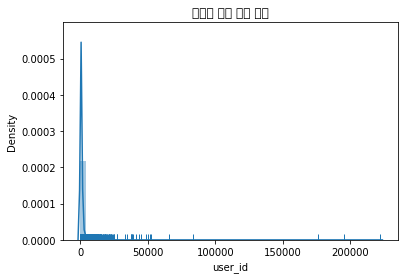

In [ ]:
sns.distplot(err_user, kde=True, rug=True)
plt.title("유저별 에러 로그 빈도")

### model_nm

In [ ]:
err_model = train_err['model_nm'].value_counts()
err_model

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

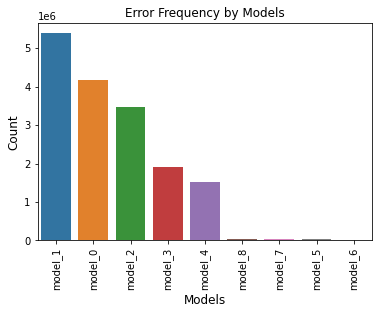

In [ ]:
sns.barplot(x = err_model.index,y = err_model.values)
plt.title("Error Frequency by Models")
plt.xticks(rotation='vertical')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.show()

In [ ]:
# model0,1,2,3,4 모델은 오류 빈도가 높은편. 

### fwver

In [ ]:
err_fwver = train_err['fwver'].value_counts()
err_fwver

In [ ]:
#시각화 
plt.figure(figsize=(12,8))
sns.barplot(x=err_fwver.index,y = err_fwver.values, color=color[5]) 
plt.ylabel('Count', fontsize=12)
plt.xlabel('Firmware Version', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Errors by Firmware Version", fontsize=15)
plt.show()

--> 특정 펌웨어 버젼에서 오류가 자주 발견됨을 볼 수 있음.

### errtype

In [ ]:
err_errtype = train_err['errtype'].value_counts()
err_errtype

In [ ]:
#시각화 
plt.figure(figsize=(12,8))
sns.barplot(x=err_errtype.index,y = err_errtype.values, color=color[1]) 
plt.ylabel('Count', fontsize=12)
plt.xlabel('Error Type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Errors by Error Type", fontsize=15)
plt.show()

In [ ]:
# 다른 컬럼과 섞어봐도 좋을듯. 어떤 error type이 많이 발생하는지 진단.

errtype, user_id

errtype, model_nm

errtype, fwver

In [ ]:
train_quality
#시스템 퀄리티 로그
# quality?

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


In [ ]:
train_problem
#사용자 불만 및 불만이 접수된 시간

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000
...,...,...
5424,20167,20201125120000
5425,16270,20201110120000
5426,19114,20201106230000
5427,21505,20201104110000


In [ ]:
sample_submission

,user_id,problem
0,30000,0
1,30001,0
2,30002,0
3,30003,0
4,30004,0
...,...,...
14994,44994,0
14995,44995,0
14996,44996,0
14997,44997,0


##train_problem

In [ ]:
train_problem
# 시

,user_id,err_received_time
0,19224,2020-11-02 20:00:00
1,23664,2020-11-16 14:00:00
2,15166,2020-11-14 13:00:00
3,12590,2020-11-08 21:00:00
4,15932,2020-11-03 21:00:00
...,...,...
5424,20167,2020-11-25 12:00:00
5425,16270,2020-11-10 12:00:00
5426,19114,2020-11-06 23:00:00
5427,21505,2020-11-04 11:00:00


## train_quality

In [ ]:
train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


In [ ]:
train_quality.iloc[:,3:].sum(axis = 0)

quality_0                                           2.83851e+06
quality_1                                               -142343
quality_2                                           3.74629e+06
quality_3                                                     0
quality_4                                                     0
quality_6                                               1693203
quality_10    4444444444448888888888880000000000002222222222...
quality_11                                              -150510
quality_12                                                38016
dtype: object

In [ ]:
prob_user = train_problem['user_id']
pd.merge(train_quality,prob_user)

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000
...,...,...
5424,20167,20201125120000
5425,16270,20201110120000
5426,19114,20201106230000
5427,21505,20201104110000


#4.Model

# df화

idea: 
1.원래 쿠사리 넣는 사람인지 test_user
2.시간대

위 1,2정보는 적용에 문제가 있음.
1.의 경우 해당 컬럼 만으로는 쓸 수 없음. user 가 test, train과 다름.
하지만 유저들이 몰리는 시간 - quality 상관관계는 볼 수 있을 듯.

2.의 경우는 test set에서는 불만이 접수된 시점에 
하지만 불만 접수는 서비스 이후 시점에서 드러나는것.
따라서 
test set 이전의 로그 기록들 때문에 문제를 제기했다고 봐도 좋을 듯.
(로그들을 모아 --> 한 시퀀스로 만들기)


In [ ]:
#baseline 코드
id_error = train_err[['user_id','errtype']].values

#어떤 타입의 에러가 발생했는지.
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error): #tqdm(리스트) -->하면 리스트를 도는 반복문 추이를 보여줌.
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

#문제가 접수 되었는지. 
problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1 
problem
train = pd.DataFrame(data=error)
train['problem'] = problem
del error, problem

100%|██████████| 16554663/16554663 [00:48<00:00, 344399.09it/s]


## 0) basseline + AutoML

In [ ]:
#best 1 도 진행.
# best one : 
clf = setup(data = train, target = 'problem') 

best = compare_models(sort = 'AUC')
#the best model, catboost.
catboost = create_model('catboost')
#tuning
tuned_catboost = tune_model(catboost)


# # #
final_model = finalize_model(tuned_catboost)

#test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)
# #
predictions = predict_model(final_model, data = test)
# # #
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])
# #
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x

sample_submssion.to_csv(PATH+"AutoML_best_catboost.csv", index = False)

,Description,Value
0,session_id,7591
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 43)"
5,Missing Values,False
6,Numeric Features,42
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


IntProgress(value=0, description='Processing: ', max=79)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:38:18
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7750,0.7991,0.4872,0.7548,0.5919,0.4465,0.4670,0.335
gbc,Gradient Boosting Classifier,0.7745,0.7985,0.4526,0.7836,0.5735,0.4349,0.4653,2.082
et,Extra Trees Classifier,0.7760,0.7941,0.4736,0.7699,0.5859,0.4443,0.4691,1.654
rf,Random Forest Classifier,0.7743,0.7919,0.4636,0.7723,0.5790,0.4378,0.4646,1.876
xgboost,Extreme Gradient Boosting,0.7706,0.7870,0.5128,0.7229,0.5998,0.4455,0.4586,5.937
ada,Ada Boost Classifier,0.7678,0.7859,0.4599,0.7513,0.5700,0.4235,0.4476,0.571
lda,Linear Discriminant Analysis,0.7467,0.7402,0.3267,0.7987,0.4631,0.3340,0.3913,0.098
qda,Quadratic Discriminant Analysis,0.7282,0.7355,0.2849,0.7500,0.4114,0.2791,0.3348,0.058
nb,Naive Bayes,0.7312,0.7348,0.2818,0.7714,0.4117,0.2841,0.3447,0.044
lr,Logistic Regression,0.7482,0.7319,0.3585,0.7654,0.4878,0.3490,0.3932,1.736


100%|██████████| 16532648/16532648 [00:48<00:00, 341770.05it/s]


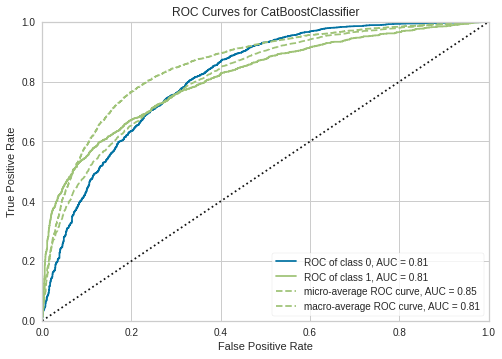

In [ ]:
# tuned_catboost
#AUC
plot_model(estimator = tuned_catboost, plot = 'auc')


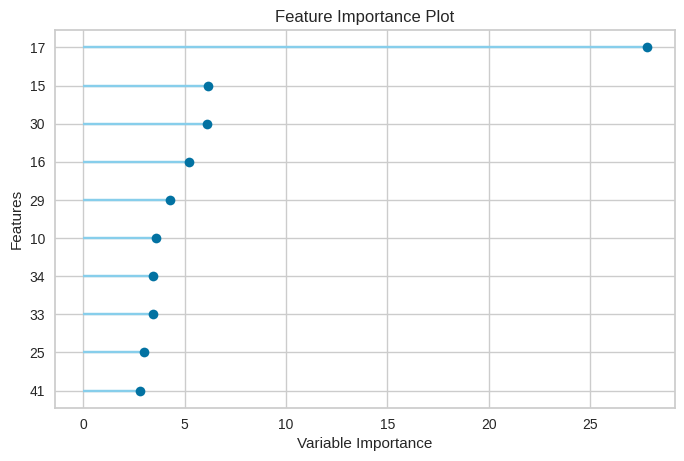

In [ ]:
plot_model(estimator = tuned_catboost, plot = 'feature')

### best 3

In [ ]:
# best 3 blend
clf = setup(data = train, target = 'problem') 

best_3 = compare_models(sort = 'AUC', n_select = 3)

blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')
# #
pred_holdout = predict_model(blended)
# #
final_model = finalize_model(blended)

#test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)
# #
predictions = predict_model(final_model, data = test)
# #
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])
# #
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x

sample_submssion.to_csv(PATH+"AutoML_best3.csv", index = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7886,0.8163,0.4739,0.8015,0.5956,0.4650,0.4944
1,0.7662,0.7870,0.4377,0.7457,0.5516,0.4076,0.4341
2,0.7881,0.8194,0.4957,0.7790,0.6058,0.4706,0.4931
3,0.7910,0.8203,0.5065,0.7812,0.6146,0.4800,0.5012
4,0.7789,0.8030,0.4696,0.7678,0.5827,0.4440,0.4688
Mean,0.7826,0.8092,0.4767,0.7750,0.5901,0.4534,0.4783
SD,0.0091,0.0127,0.0238,0.0183,0.0220,0.0258,0.0247


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.778,0.7972,0.4893,0.7847,0.6028,0.46,0.4847


100%|██████████| 16532648/16532648 [00:47<00:00, 348579.71it/s]


### best 4

In [ ]:
# best 4 blend
clf = setup(data = train, target = 'problem') 

best_4 = compare_models(sort = 'AUC', n_select = 4)

blended = blend_models(estimator_list = best_4, fold = 5, method = 'soft')
# #
pred_holdout = predict_model(blended)
# #
final_model = finalize_model(blended)

#test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)
# #
predictions = predict_model(final_model, data = test)
# #
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])
# #
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x

sample_submssion.to_csv(PATH+"AutoML_best4.csv", index = False)

,Description,Value
0,session_id,8706
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 43)"
5,Missing Values,False
6,Numeric Features,42
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


### best5

In [ ]:
# best 5 blend
clf = setup(data = train, target = 'problem') 

best_5 = compare_models(sort = 'AUC', n_select = 4)

blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')
# #
pred_holdout = predict_model(blended)
# #
final_model = finalize_model(blended)

#test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)
# #
predictions = predict_model(final_model, data = test)
# #
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])
# #
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x

sample_submssion.to_csv(PATH+"AutoML_best5.csv", index = False)

### best6

In [ ]:
# best 6 blend
clf = setup(data = train, target = 'problem') 

best_6 = compare_models(sort = 'AUC', n_select = 4)

blended = blend_models(estimator_list = best_6, fold = 5, method = 'soft')
# #
pred_holdout = predict_model(blended)
# #
final_model = finalize_model(blended)

#test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)
# #
predictions = predict_model(final_model, data = test)
# #
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])
# #
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x

sample_submssion.to_csv(PATH+"AutoML_best6.csv", index = False)

### best7

In [ ]:
# best 7 blend
clf = setup(data = train, target = 'problem') 

best_7 = compare_models(sort = 'AUC', n_select = 4)

blended = blend_models(estimator_list = best_7, fold = 5, method = 'soft')
# #
pred_holdout = predict_model(blended)
# #
final_model = finalize_model(blended)

#test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)
# #
predictions = predict_model(final_model, data = test)
# #
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])
# #
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x

sample_submssion.to_csv(PATH+"AutoML_best7.csv", index = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7633,0.7827,0.4370,0.7457,0.5510,0.4049,0.4315
1,0.7838,0.8043,0.4907,0.7755,0.6011,0.4629,0.4857
2,0.7843,0.8161,0.4735,0.7933,0.5930,0.4587,0.4870
3,0.7881,0.8181,0.5050,0.7788,0.6127,0.4758,0.4970
4,0.7766,0.8009,0.4620,0.7740,0.5786,0.4395,0.4666
Mean,0.7792,0.8044,0.4736,0.7735,0.5873,0.4484,0.4735
SD,0.0088,0.0127,0.0235,0.0155,0.0212,0.0247,0.0232


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7798,0.8114,0.4729,0.7877,0.591,0.4529,0.4805


100%|██████████| 16532648/16532648 [00:46<00:00, 356815.34it/s]


In [ ]:
predictions['Label']

0        1.0
1        0.0
2        0.0
3        1.0
4        1.0
        ... 
14994    0.0
14995    0.0
14996    1.0
14997    1.0
14998    0.0
Name: Label, Length: 14999, dtype: object

In [ ]:
sample_submssion.to_csv(PATH+"AutoML_best4.csv", index = False)

In [ ]:
sample_submssion

,user_id,problem
0,30000,0.9287
1,30001,0.2075
2,30002,0.2615
3,30003,0.7953
4,30004,0.6823
...,...,...
14994,44994,0.2931
14995,44995,0.2992
14996,44996,0.6425
14997,44997,0.8134


In [ ]:
#난수 생성
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
predictions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,Label,Score
0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,0.0,2.0,1.0,0.9287
1,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7925
2,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,1.0,2.0,0.0,0.7385
3,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,8.0,0.0,1.0,0.7953
4,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,90.0,0.0,1.0,0.6823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.0,0.0,0.0,2.0,12.0,5.0,5.0,0.0,0.0,0.0,16.0,19.0,3.0,9.0,123.0,93.0,12.0,0.0,0.0,0.0,0.0,197.0,204.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,179.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,87.0,0.0,0.0,0.7069
14995,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,14.0,15.0,1.0,4.0,149.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,183.0,0.0,14.0,1.0,0.0,1.0,1.0,0.0,0.0,12.0,17.0,0.0,0.0,0.7008
14996,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,12.0,13.0,1.0,3.0,129.0,90.0,2.0,0.0,0.0,0.0,0.0,138.0,165.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,163.0,0.0,12.0,1118.0,0.0,1.0,1.0,1.0,0.0,329.0,2.0,3.0,1.0,0.6425
14997,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,0.0,0.0,15.0,16.0,0.0,1.0,73.0,44.0,0.0,1.0,0.0,1.0,0.0,11127.0,13161.0,0.0,3.0,44.0,0.0,0.0,0.0,0.0,78.0,0.0,14.0,0.0,0.0,1.0,1.0,3.0,0.0,30.0,49.0,0.0,1.0,0.8134


## 1) ANN

baseline df. 기준코드. feature추가 필요.

In [ ]:
#train_test_split

x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
x_train



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Min_Max_scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(x_train) 

df_scaled = pd.DataFrame(data = scaled, columns = x_train.columns)
df_scaled
x_train.reset_index(drop = True, inplace = True)
x_train

In [ ]:
#모델 만들기 
def build_model():
 model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(1)])
 #optimizer = tf.keras.optimizers.RMSprop(0.05)
 model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
 return model

model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 8)                 344       
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 3         
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 30)

#모델 학습
history = model.fit(
  x_train, y_train,
  epochs= 100, validation_split = 0.2, verbose=1)



Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 134.6630 - accuracy: 0.6605 - val_loss: 0.3503 - val_accuracy: 0.6613
Epoch 2/100
375/375 [==============================] - 0s 1ms/step - loss: 13.2936 - accuracy: 0.6661 - val_loss: 0.3128 - val_accuracy: 0.6613
Epoch 3/100
375/375 [==============================] - 0s 1ms/step - loss: 6.3835 - accuracy: 0.6612 - val_loss: 0.2747 - val_accuracy: 0.6613
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 1.7637 - accuracy: 0.6698 - val_loss: 0.2499 - val_accuracy: 0.6613
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 1.2902 - accuracy: 0.6679 - val_loss: 0.2358 - val_accuracy: 0.6613
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 2.7016 - accuracy: 0.6698 - val_loss: 0.2283 - val_accuracy: 0.6613
Epoch 7/100
375/375 [==============================] - 0s 1ms/step - loss: 0.7937 - accuracy: 0.6683 - val_loss: 0.2256 - val_accuracy: 0.6

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

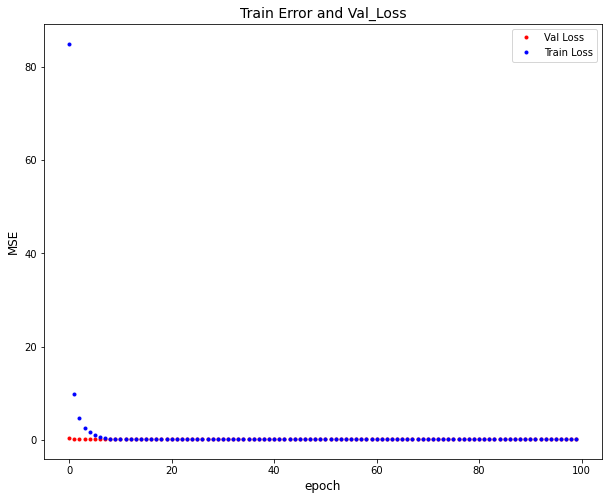

In [ ]:
# 학습경과

y_vloss = history.history['val_loss']
y_mse = history.history['loss']

x_len = np.arange(len(y_mse))

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(x_len, y_vloss, "o",c = "red", markersize = 3)


plt.plot(x_len, y_mse, "o", c = "blue", markersize = 3)


plt.title('Train Error and Val_Loss', fontsize=14)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.legend(['Val Loss','Train Loss'])


plt.show()
